# Baseline experiment of Wilkes et al. method.

This is the baseline experiment for our master thesis.

In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt

temporary directory at: /tmp/lidar.processing.437933.tmp
number of tiles to process: 1
number of bad points: 0


Text(0.5, 0, 'number of returns')

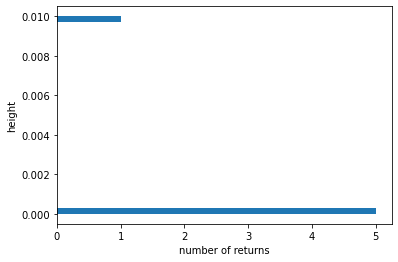

In [2]:
# import lasIO from ForestLAS
from forestlas import lasIO

# reads .las file "WC1.las" including all point metadata in verbose mode
las = lasIO.lasIO(os.path.join(os.getcwd(), 'WC1.las'), keepTemp=True,
                  verbose=True)

# returns as an numpy array
lasAll = las.all().asArray()

# plot histogram of height
plt.hist(lasAll['z'], 
         #(lasAll['z'].max() / 2).astype(int), 
         36,
         orientation="horizontal")
plt.ylabel("height")
plt.xlabel("number of returns")

In [3]:
# data can also be tiled
# here we tile a plot into 9 subplots...
lasTiles = las.tiling(8).asArray()

# ...and plot histograms of height
f, a = plt.subplots(3, 3, sharex=True, sharey=True)
for i, tile in enumerate(lasTiles): 
    ax = a[i//3][i%3]
    ax.hist(tile['z'], bins=40, range=(0, 80), orientation="horizontal")
f.subplots_adjust(hspace=0, wspace=0)

number of plots: 4


ZeroDivisionError: integer division or modulo by zero

number of bad points = 0


TypeError: list indices must be integers or slices, not str

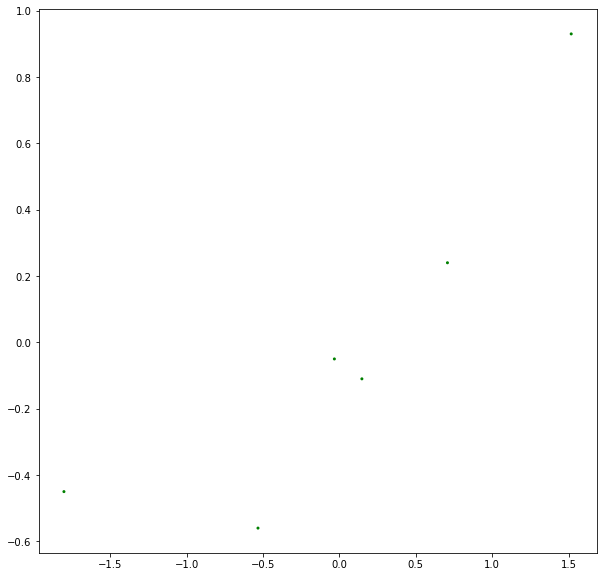

In [4]:
# data can also be extracted as a subplot
# first extract the plot centre coordinates
header = lasIO.parseHeader(os.path.join(os.getcwd(), 'WC1.las'))
x = np.mean([header["xmin"], header["xmax"]])
y = np.mean([header["ymin"], header["ymax"]])

# then extract returns from a 5 m diameter from the plot centre
# lasSubPlot = las.plot(x, y, radius=5, round=True).asArray()

lasSubPlot = las.plot(x, y, extent=5, round=True).asArray()

# and graph the complete plot and the subset
plt.figure(figsize=(10,10))
plt.scatter(lasAll['x'], lasAll['y'], marker=".",
            c="green", edgecolor="none")
plt.scatter(lasSubPlot['x'], lasSubPlot['y'], marker=".", 
            c="red", edgecolor="none")

## Lets now create a canopy height profile

In [7]:
from forestlas import canopyComplexity as cc
import os, glob
import numpy as np
import matplotlib.pyplot as plt

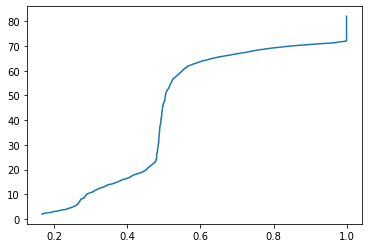

In [8]:
# canopy height profiles are created from gap probability
# canopyComplexity calls lasIO so there is no need to bring in .las files beforehand

las = cc.CanopyComplexity().fromLAS(os.path.join(os.getcwd(), 'WC1.las'))
pg = las.Pgap()

# lets take a look for our plot
plt.plot(pg.pgap, pg.zxOrig)

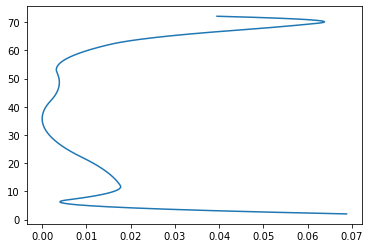

In [11]:
#%autoreload 2
# if we plot the first derivative of this we see the CHP is 
# pretty noisy! Alpha is set to 0 so there is no smoothing
# applied
chp = las.CHP(alpha=0.3)
plt.plot(chp.fd, chp.zx)

<ipython-input-13-0edabd8c5169>:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  h, b = np.histogram(chp.z, (chp.z.max() / 2).astype(int), normed=True)


<BarContainer object of 36 artists>

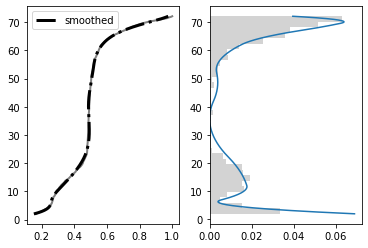

In [13]:
# through a supervised classification and cross validation an alpha
# parameter of 0.3 was identified as a suboptimal value for the 
# nonparametric spline smoothing (this is the default)

chp = cc.CanopyComplexity().fromLAS(os.path.join(os.getcwd(), 'WC1.las')).CHP()

# freq = cc.CanopyComplexity().fromLAS(os.path.join(lasFiles, "WC6.las"))
# freq = freq.canopyHeightProfile(frequency=True)

plt.subplot(121)
plt.plot(chp.pgap, chp.zx, "-", color="grey", linewidth=2)
plt.plot(chp.ps, chp.zx, "-.", color="black", linewidth=3, label="smoothed")
plt.legend(loc=2)

plt.subplot(122)
plt.plot(chp.fd, chp.zx)
#plt.plot(freq.fd, freq.zx, "r")
h, b = np.histogram(chp.z, (chp.z.max() / 2).astype(int), normed=True)
plt.barh(b[1:] - 1, h * (1 - chp.pgap.min()), height=2, fc="lightgrey")

Number of canopy layers: 3


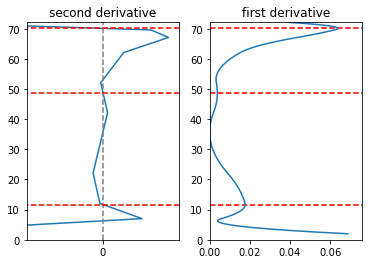

In [14]:
# from smmothed estimate of Pgap we can then take the second
# derivative to estimate the number of canopy layers

plt.subplot(121)
plt.plot(chp.sd, chp.zx)
plt.xlim(-0.01, 0.01)
plt.plot([0, 0], [0, 80], "--", color="grey")
for layer in chp.layerLocation:
    plt.plot([-1, 1], [layer, layer], "--r",)
plt.xticks([0])
plt.title("second derivative")
plt.ylim(0, chp.z.max())

plt.subplot(122)
for layer in chp.layerLocation:
    plt.plot([0, 1], [layer, layer], "--r",)
plt.plot(chp.fd, chp.zx)
plt.xlim(0, chp.fd.max() * 1.1)
plt.title("first derivative")
plt.ylim(0, chp.z.max())

print("Number of canopy layers:", chp.layerCount)

Text(0, 0.5, 'probsbility')

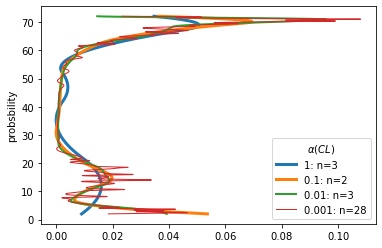

In [15]:
# 3 canopy layers may be considered an overestimtion of CL,
# one solution is to change the alpha paramter in the 
# las.canopyHeightProfile(alpha=x) call

for i, (alpha, lw) in enumerate(zip([1, 0.1, 0.01, 0.001],
                                    [3, 3, 2, 1])):
    chp = las.CHP(alpha=alpha)
    plt.plot(chp.fd, chp.zx, linewidth=lw, 
             label="{}: n={}".format(alpha, chp.layerCount),
             zorder=i)
    
plt.legend(loc="best", title=r"$\alpha (CL)$")
plt.ylabel("height (m)")
plt.ylabel("probsbility")

In [ ]:
# We can take a closer look at individual iterations to see how 
# the CHP configuration changes

num = 10

f, a = plt.subplots(2, 5, figsize=(20, 5), sharey=True, sharex=True)
las = cc.CanopyComplexity().fromLAS(os.path.join(os.getcwd(), "WC1.las")).CHP("model")

for bsi in range(num):
    ax = a[bsi//5][bsi%5]
    zs = las.simulateCloud()
    CHPi = cc.CanopyComplexity().fromLAS(zs).CHP()
    ax.plot(CHPi.fd, CHPi.zx)
    ax.text(0.06, 2, 
            "$CL$: {}".format(CHPi.layerCount),
            fontsize=18)
    if bsi == 0:    
        ax.set_ylabel("height (m)")
    ax.set_xlim(0, 0.09)
        
f.subplots_adjust(hspace=0, wspace=0)
f.text(0.12, 0, "N.B. local maxima which are <5% of the largest peak are not counted", fontsize=18)

In [1]:
from forestlas import canopyComplexity as cc
# required for demonstration
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# THIS WILL REQUIRE YOUR OWN SET OF .las FILES

# Instead of passing a single .las file the function will also accept a 
# directory, and in this instance will run across multiple CPU's.  
# The default number is 4 CPU;s; this can be changed by passing the 
# argument processes=x
#
# An example of a command if running on a server with multiple CPU's could be:
# bs = cc.bootstrapComplexity(os.getcwd(), N=100, processes=20, verbose=False)

start_loading = time.time()

#os.chdir(lasFiles)
lasList = glob.glob(os.path.join(os.getcwd(), 'SLU_laserdata', 'all_las', '*.las'))
bsMulti = cc.bootstrapComplexity(lasList, N=100, processes=8, verbose=False)

end_loading = time.time()

start_loop = time.time()

for plot in bsMulti.bsCHPmutiple.keys():
    #print("################")
    print(plot, bsMulti.bsCHPmutiple[plot].mean())
    #print(plot, bsMulti.bsCHPmutiple[plot])

end_loop = time.time()
print(end_loading - start_loading)
print(end_loop - start_loop)

831555112832 0.59
831555206830 0.0
831555106830 0.0
831540206830 0.0
831540412830 0.56
831540306830 0.66
831540212830 0.39
831540112830 0.09
831555212830 1.0
13.406127214431763
0.0018761157989501953
